# 0. Milestone 2 overview

## Simple Baseline Description
For our simple baseline, we implemented a majority class baseline. This baseline takes the majority class from the training data (this was a 5 rating), and uses that as the prediction for all inputs in the validation and test set.

## Sample Output of simple-baseline.py

*output:*
total_nas=3
majority_rating=5.0
Validation accuracy: 53.40%
Test accuracy: 53.32%
Validation and test predictions saved to CSV in the required format.


## Score of majority class baseline on test set
Test accuracy: 53.32%

Our simple baseline correctly predicted the rating column of our test set 53.32 percent of the time.

## Evaluation using our scoring script
Due to the unique nature of our classification task, we were recommended to have a regression evaluation as well.
This is due to the fact that our classification correctness should not be binary. Predicting 4 on a ground truth
of 5 is a lot better than predicting a 1. Because there are levels of "wrongness", we additionally use regression
to evaluate our baselines. Below you can find the results of test.csv being evaluated by our scripts.


*script*
% python3.11 scoring_regression.py test.csv test.csv --true_column ground_truth --pred_column predictions

*output:*
Mean Absolute Error: 1.2291
Mean Squared Error: 3.9663
R2 Score: -0.6152


*script:*
% python3.11 scoring_classification.py test.csv test.csv --true_column ground_truth --pred_column predictions

*output:*
Accuracy: 0.5332
Macro Precision: 0.1066
Macro Recall: 0.2000
Macro F1-Score: 0.1391

# 1. Data

## a. Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# change this line for your data directory
# %cd /content/drive/MyDrive/Junior\ Year/CIS\ 4300/project/data
# %cd /content/drive/MyDrive/CIS\ 5300
# %cd /content/drive/MyDrive/CIS\ 5300/data
# %cd /content/drive/MyDrive/data
#%cd /content/drive/MyDrive/'forms documents'/CIS5300
%cd /content/drive/MyDrive/'Colab Notebooks'/CIS5300

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/CIS5300


## b. Load datasets

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
val = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [ ]:
print(f"Original train set size: {len(train)}")

Original train set size: 336239


Since the train dataset is very large and results in very long running times for models, we truncate it to $50,000$ rows, about 15\% of the original size.  This is because constructing data during the augmentation process is very time-consuming and does not have much room to be optimized by GPU.

In [ ]:
train = train.sample(frac=50000/336239, random_state=42)
print(f"Truncated train set size: {len(train)}")

Truncated train set size: 50000


In [ ]:
print(f"Truncated train set size: {len(train)}")
print(f"Val set size: {len(val)}")
print(f"Test set size: {len(test)}")

Truncated train set size: 50000
Val set size: 72052
Test set size: 72051


In [ ]:
test.head()

,name,text,rating,difficulty,date
0,Regina Smith,She's super vague on all instructions and resp...,1.0,4.0,2019-08-28
1,Arezoo Emadi,"If you see this profs name, do yourself a favo...",1.0,5.0,2024-01-02
2,Lucas Keefer,Very very funny and easy to listen to when he ...,5.0,3.0,2019-11-20
3,Yuan Hu,The class itself was simple enough but the lec...,2.0,3.0,2021-12-04
4,Raphael St-Gelais,"He's a new teacher, but explains concepts real...",5.0,4.0,2019-01-15


There are also some missing values in the train data `text` column (the description of the rating).  There are only `3` in the entire dataset and there happens to be none in the sample.

In [ ]:
total_nas = train['text'].isna().sum()
print(f"{total_nas=}")

# still want to reset index
train = train.dropna(subset=['text']).reset_index(drop=True)

total_nas=0


There also aren't any in the `val` or `test` data.

In [ ]:
val['text'].isna().sum()
test['text'].isna().sum()

0

## c. Exploratory Data Analysis

We have 9 classes for `rating`; these are in increments of $0.5$ on the interval $[1.0,5.0]$, inclusive.

In [ ]:
NCLS_RATING = len(train['rating'].unique())
NCLS_DIFFICULTY = len(train['difficulty'].unique())

print(f"n classes rating: {NCLS_RATING}")
print(f"n classes difficulty: {NCLS_DIFFICULTY}")

n classes rating: 8
n classes difficulty: 5


Below is the class distribution among training data.  Fractional ratings are uncommon, and the distribution is roughly bimodal with most `rating` values being $5.0$ or $1.0$.

In [ ]:
summary_df = pd.DataFrame({
    'Value counts':         train['rating'].value_counts(),
    'Value percentages':    train['rating'].value_counts(normalize=True)*100
})
summary_df

,Value counts,Value percentages
rating,,
5.0,26678,53.356
1.0,8897,17.794
4.0,6690,13.380
2.0,3889,7.778
3.0,3834,7.668
4.5,7,0.014
3.5,3,0.006
2.5,2,0.004


<ipython-input-36-33626197982a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bins, y=rating_counts, palette='viridis')


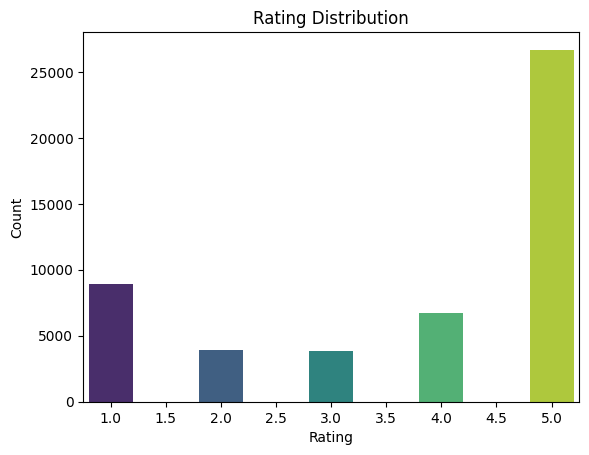

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = np.arange(1.0, 5.5, 0.5)
rating_counts = train['rating'].value_counts().sort_index()
rating_counts = [rating_counts.get(val, 0) for val in bins]

sns.barplot(x=bins, y=rating_counts, palette='viridis')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

# 2. Define Evaluation Metrics

Initially, we believed our task to be a classification task, but a regression task seems to be more fitting. For example, for a true value of 5.0, if the model predicts a rating of 4.5, that is a much better estimate than 2.0. However, for classification models, that 4.5 output would be penalized equally to the 2.0 estimate.

**Regression** - Our evaluation metrics are accuracy, mean absolute error, mean squared error, and R-Squared. Accuracy is calculated plainly as the number of times a model got a classification correct divided by the total number of times it has made classifications. Mean absolute error takes the average of the absolute differences between predicted and true ratings. The equation for MAE is $MAE = \frac{1}{N} \sum_{i=1}^N |y_{i} - \hat{y}_{i}|$ where $N$ is the sample size, y is the true value, and y hat is the predicted value. A smaller MAE value is better. R-Squared calculates the proportion of variance in the true ratings explained by the predictions, and is a good evaluation metric for our use case. The equation for R-Squared is $R^2 = 1 - \frac{\sum_{i=1}^N (y_{i} - \hat{y}_{i})^2}{\sum_{i=1}^N (y_{i} - \bar{y})^2}$, where y-bar represents the average of the true values $y_{i}$. A value closer to 1 is better. Mean squared error takes the average squared difference between the true and predicted ratings. The equation for MSE is $MSE = \frac{1}{n}\sum_{i=1}^N (y_{i} - \hat{y}_{i})^2$.

[This](https://pmc.ncbi.nlm.nih.gov/articles/PMC8279135/) paper goes into more depth about R-Squared Scores.

**Note**: we are currently looking into oridinal classification for this task, detailed in [this](https://ieeexplore.ieee.org/abstract/document/4633963) paper.

**Ordinal Classification** - Since our task at hand seems like an ordinal classification task, we will introduce one more evaluation metric called Quadratic Weighted Kappa (QWK). QWK measures the agreement between two raters (in our case, the model and ground truth), while also accounting for the magnitude of disagreement. To calculate QWK, we must create a confusion matrix **O** that counts the number of occurrences for each class pair. Then, we must create a weight matrix **W** that penalizes disagreements based on the squared difference. Finally, we must create the expected matrix **E** which calculates the expected agreement. The equation for QWK is $QWK = 1 - \frac{\sum{}(W \cdot O)}{\sum{}(W \cdot E)}$. Values closer to 1 are better.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, cohen_kappa_score

def calculate_metrics(y_true, y_pred, ret=True):
    # QWK requires integer values as input, so we will map 0.5 intervals to integers
    float_mapping = {v: i for i, v in enumerate(np.arange(1.0, 5.5, 0.5))}
    y_true_integer = [float_mapping[val] for val in y_true]
    # round since predictions are not always on 0.5 intervals
    y_pred_integer = [float_mapping[np.clip(np.round(val * 2) / 2, 1.0, 5.0)] for val in y_pred]

    metrics = {
        "Mean Absolute Error": mean_absolute_error(y_true, y_pred),
        "Mean Squared Error": mean_squared_error(y_true, y_pred),
        "R2 Score": r2_score(y_true, y_pred),
        "Quadratic Weighted Kappa": cohen_kappa_score(y_true_integer, y_pred_integer, weights='quadratic')
    }

    if ret: return metrics
    for k in metrics:
        print(f"{k}: {metrics[k]:.3f}")

In [ ]:
# EXAMPLE
y_true = [1.0, 2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 2.0]
y_pred = [2.0, 3.0, 5.0, 4.0, 5.0, 1.0, 3.0, 2.0]
calculate_metrics(y_true, y_pred, ret=False)

Mean Absolute Error: 0.625
Mean Squared Error: 0.875
R2 Score: 0.391
Quadratic Weighted Kappa: 0.745


# 3. Baseline Models

## a. Simple Baseline (Majority-Class)

For our simple baseline, we implemented a majority class baseline. This baseline takes the majority class from the training data (in this case, it was a rating of $5$), and uses that as the prediction for all inputs in the validation and test set.



In [ ]:
# Determine the majority class in the 'rating' column
majority_rating = train["rating"].mode()[0]

# Make majority class predictions
train_predictions = [majority_rating] * len(train)
val_predictions = [majority_rating] * len(val)
test_predictions = [majority_rating] * len(test)

In [ ]:
mc_bl_metrics = pd.DataFrame({
    "Train Metrics": calculate_metrics(train["rating"].tolist(), train_predictions),
    "Val Metrics": calculate_metrics(val["rating"].tolist(), val_predictions),
    "Test Metrics": calculate_metrics(test["rating"].tolist(), test_predictions),
})
mc_bl_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,1.233,1.227,1.229
Mean Squared Error,3.988,3.967,3.966
R2 Score,-0.615,-0.611,-0.615
Quadratic Weighted Kappa,0.000,0.000,0.000


**Note**: 0 for QWK value is expected behavior for the majority class! Awesome :)

## b. Stronger Baseline (LSTM)


In [ ]:
import torch
import torch.nn as nn

batch_size = 64

class LSTMRegressor(nn.Module):
    def __init__(self,
                 n_embed=20000,
                 d_embed=300,
                 d_hidden=150,
                 d_out=1, # Output size is 1 for regression
                 embeddings=None,
                 nl=2
                 ):
        super(LSTMRegressor, self).__init__()
        self.embedding = nn.Embedding(n_embed, d_embed)
        self.lstm = nn.LSTM(d_embed, d_hidden, nl, batch_first=True)
        self.fc = nn.Linear(d_hidden, d_out)  # Output layer for regression

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_hidden_state = lstm_out[:, -1, :]  # Take the last hidden state
        output = self.fc(final_hidden_state)
        return output  # Return the raw regression output

In [ ]:
test.head()

,name,text,rating,difficulty,date
0,Regina Smith,She's super vague on all instructions and resp...,1.0,4.0,2019-08-28
1,Arezoo Emadi,"If you see this profs name, do yourself a favo...",1.0,5.0,2024-01-02
2,Lucas Keefer,Very very funny and easy to listen to when he ...,5.0,3.0,2019-11-20
3,Yuan Hu,The class itself was simple enough but the lec...,2.0,3.0,2021-12-04
4,Raphael St-Gelais,"He's a new teacher, but explains concepts real...",5.0,4.0,2019-01-15


In [ ]:
from collections import Counter

class TextToIndex:
    def __init__(self, max_vocab_size=None):
        self.word_to_index = {}
        self.index_to_word = {}
        self.max_vocab_size = max_vocab_size
        self.special_tokens = ["<PAD>", "<UNK>"]

    def build_vocab(self, texts):
        tokens = [word for text in texts for word in text.split(' ')]

        word_counts = Counter(tokens)
        vocab = self.special_tokens.copy()
        for word, freq in word_counts.most_common(self.max_vocab_size):
            vocab.append(word)

        self.word_to_index = {word: idx for idx, word in enumerate(vocab)}
        self.index_to_word = {idx: word for word, idx in self.word_to_index.items()}

    def text_to_sequence(self, text):
        return [self.word_to_index.get(word, self.word_to_index["<UNK>"]) for word in text.split()]

    def sequence_to_text(self, sequence):
        return " ".join([self.index_to_word.get(idx, "<UNK>") for idx in sequence])

# initalize tokenizer
tokenizer = TextToIndex(max_vocab_size=100)
tokenizer.build_vocab(train['text'].tolist())

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class RMPDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=50):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokenized = self.tokenizer.text_to_sequence(text)

        # pad sequence to max_len
        if len(tokenized) < self.max_len:
            tokenized += [self.tokenizer.word_to_index["<PAD>"]] * (self.max_len - len(tokenized))
        else:
            tokenized = tokenized[:self.max_len]

        tokenized = torch.tensor(tokenized, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.float)
        return tokenized, label

In [ ]:
# Define the model
model = LSTMRegressor(
    n_embed=len(tokenizer.word_to_index),
    d_hidden=150,
    nl=1,
    d_out=1  # Regression predicts a single continuous value
)

# Define the training function
def train_model(model, dataloader, epochs=7, lr=0.001):
    criterion = nn.MSELoss()  # Use Mean Squared Error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        model.train()

        for inputs, labels in dataloader:
            optimizer.zero_grad()

            outputs = model(inputs).squeeze()  # Squeeze output for comparison
            # labels = labels.float()  # Ensure labels are float for regression
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

In [ ]:
# Train the model
scaler = MinMaxScaler()
train_labels_scaled = scaler.fit_transform(train['rating'].values.reshape(-1, 1))
train_dataset = RMPDataset(train['text'], train_labels_scaled, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_model(model, train_dataloader)

Epoch [1/7], Loss: 0.1197
Epoch [2/7], Loss: 0.0905
Epoch [3/7], Loss: 0.0844
Epoch [4/7], Loss: 0.0797
Epoch [5/7], Loss: 0.0756
Epoch [6/7], Loss: 0.0717
Epoch [7/7], Loss: 0.0682


In [ ]:
def predict(model, dataloader, scaler):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs).squeeze()  # Get raw regression outputs
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    original_true_labels = scaler.inverse_transform(true_labels.reshape(-1, 1))

    return original_predictions, original_true_labels

In [ ]:
train_y_pred, train_y_true = predict(model, train_dataloader, scaler)

In [ ]:
train_metrics = calculate_metrics(train_y_true.ravel(), train_y_pred.ravel())
train_metrics

{'Mean Absolute Error': 0.71786267,
 'Mean Squared Error': 0.9727244,
 'R2 Score': 0.6060080528259277,
 'Quadratic Weighted Kappa': 0.7479462749137233}

In [ ]:
val_labels_scaled = scaler.transform(val['rating'].values.reshape(-1, 1))
val_dataset = RMPDataset(val['text'], val_labels_scaled, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_y_pred, val_y_true = predict(model, val_dataloader, scaler)
val_metrics = calculate_metrics(val_y_true.ravel(), val_y_pred.ravel())

In [ ]:
test_labels_scaled = scaler.transform(test['rating'].values.reshape(-1, 1))

test_dataset = RMPDataset(test['text'], test_labels_scaled, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_y_pred, test_y_true = predict(model, test_dataloader, scaler)

test_metrics = calculate_metrics(test_y_true.ravel(), test_y_pred.ravel())

In [ ]:
lstm_bl_metrics = pd.DataFrame({
    "Train Metrics": train_metrics,
    "Val Metrics": val_metrics,
    "Test Metrics": test_metrics,
})
lstm_bl_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.718,0.859,0.860
Mean Squared Error,0.973,1.400,1.402
R2 Score,0.606,0.432,0.429
Quadratic Weighted Kappa,0.748,0.633,0.631


In [ ]:
np.savetxt(f"lstmbl_train_pred.txt", train_y_pred, fmt="%s")
np.savetxt(f"lstmbl_val_pred.txt", val_y_pred, fmt="%s")
np.savetxt(f"lstmbl_test_pred.txt", test_y_pred, fmt="%s")

## c. Compare Baseline Metrics

In [ ]:
mc_bl_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,1.233,1.227,1.229
Mean Squared Error,3.988,3.967,3.966
R2 Score,-0.615,-0.611,-0.615
Quadratic Weighted Kappa,0.000,0.000,0.000


In [ ]:
lstm_bl_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.718,0.859,0.860
Mean Squared Error,0.973,1.400,1.402
R2 Score,0.606,0.432,0.429
Quadratic Weighted Kappa,0.748,0.633,0.631


**Note**: It is common to look at just Mean Absolute Error (MAE) and Quadratic Weighted Kappa (QWK) for ordinal tasks, so we will be focusing our attention to those two evaluation metrics

# 4. Data Augmentation

## a. Synonym Replacement
Synonym replacement attempts to create more artificial data by taking the "text" string from a row of existing data and replacing a few words in that string with synonyms, which preserves the meaning of the sentence.

In [ ]:
import requests
import random

In [ ]:
# Using Datamuse API
def get_synonyms(word):
    url = f"https://api.datamuse.com/words?rel_syn={word}"
    response = requests.get(url)
    if response.status_code == 200:
        synonyms = [item['word'] for item in response.json()]
        return synonyms
    return []

# n is number of words you want to replace in the sentence
def synonym_replacement(text, n):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0

    for word in random_word_list:
        # there's sometimes weird behavior if you try to find a synonym for shorter words
        if len(word) > 3:
          synonyms = get_synonyms(word)
          if synonyms:
              synonym = random.choice(synonyms)
              if synonym != word:  # Make sure the synonym is different than the original word
                  new_words = [synonym if w == word else w for w in new_words]
                  num_replaced += 1
          if num_replaced >= n:
              break

    return ' '.join(new_words)

**Example of Synonym Replacement**

In [ ]:
example_text = "This professor was absolutely amazing! Definitely recommend enrolling in his course."
augmented_text = synonym_replacement(example_text, 3)
print("Original Text:", example_text)
print("Augmented Text:", augmented_text)

Original Text: This professor was absolutely amazing! Definitely recommend enrolling in his course.
Augmented Text: This professor was dead amazing! decidedly urge enrolling in his course.


**Applying Synonym Replacement on Our Data**

Once again we wil be using the undersampled training dataset so our models are computationally capable of running

In [ ]:
# We will make our train dataset 1.2x larger using synonym augmentation
num_synonym_augmentation_rows = int(len(train) * 0.2)

rows_to_augment = train.sample(n=num_synonym_augmentation_rows, random_state=42)
augmented_data = []

for index, row in rows_to_augment.iterrows():
    augmented_text = synonym_replacement(row['text'], n=3)
    augmented_data.append({'text': augmented_text, 'rating': row['rating']})

augmented_df = pd.DataFrame(augmented_data)
train_augmented = pd.concat([train, augmented_df]).reset_index(drop=True) # concating here okay? do we need to randomize data placement?

In [ ]:
augmented_df.to_csv("augmented_df_synonyms.csv", index=False)

In [ ]:
print(train_augmented)

                  name                                               text  \
0           Lisa Baker  Very knowledgeable, I felt like I was being ta...   
1       Julie Brancale  I personally really enjoyed Professor Brancale...   
2         Jacob Duncan  This class could have been way easier if he un...   
3         Josh Solomon  Josh is an amazing lecturer! He keeps students...   
4      Bridget Potocki  She is a good professor. She kinda grades hard...   
...                ...                                                ...   
59995              NaN  So far it's okay. She does only 1 extra quotat...   
59996              NaN  He is really hard for a first year class. Make...   
59997              NaN  I hatred MATH, But Prof. Naik makes it sufferable   
59998              NaN  LOVED THIS PROF!!! I will overlook him a lot. ...   
59999              NaN  Professor MacAusland is a sincerely amazing pr...   

       rating  difficulty        date  
0         5.0         1.0  2022-01-

Now we shall run the LSTM model on the newly augmented data

In [ ]:
# initialize tokenizer
tokenizer = TextToIndex(max_vocab_size=100)
tokenizer.build_vocab(train_augmented['text'].tolist())

# Define the model
model = LSTMRegressor(
    n_embed=len(tokenizer.word_to_index),
    d_hidden=150,
    nl=1,
    d_out=1  # Regression predicts a single continuous value
)

# Train the model
scaler = MinMaxScaler()
train_labels_scaled = scaler.fit_transform(train_augmented['rating'].values.reshape(-1, 1))
train_dataset = RMPDataset(train_augmented['text'], train_labels_scaled, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_model(model, train_dataloader)

Epoch [1/7], Loss: 0.1183
Epoch [2/7], Loss: 0.0894
Epoch [3/7], Loss: 0.0831
Epoch [4/7], Loss: 0.0780
Epoch [5/7], Loss: 0.0734
Epoch [6/7], Loss: 0.0692
Epoch [7/7], Loss: 0.0648


In [ ]:
train_y_pred, train_y_true = predict(model, train_dataloader, scaler)

In [ ]:
train_metrics = calculate_metrics(train_y_true.ravel(), train_y_pred.ravel())

In [ ]:
val_labels_scaled = scaler.transform(val['rating'].values.reshape(-1, 1))
val_dataset = RMPDataset(val['text'], val_labels_scaled, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_y_pred, val_y_true = predict(model, val_dataloader, scaler)
val_metrics = calculate_metrics(val_y_true.ravel(), val_y_pred.ravel())

In [ ]:
test_labels_scaled = scaler.transform(test['rating'].values.reshape(-1, 1))

test_dataset = RMPDataset(test['text'], test_labels_scaled, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_y_pred, test_y_true = predict(model, test_dataloader, scaler)

test_metrics = calculate_metrics(test_y_true.ravel(), test_y_pred.ravel())

In [ ]:
lstm_syn_aug_metrics = pd.DataFrame({
    "Train Metrics": train_metrics,
    "Val Metrics": val_metrics,
    "Test Metrics": test_metrics,
})
lstm_syn_aug_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.715,0.880,0.884
Mean Squared Error,0.928,1.431,1.445
R2 Score,0.624,0.419,0.412
Quadratic Weighted Kappa,0.762,0.628,0.624


In [ ]:
np.savetxt(f"lstm-syn-aug_train_pred.txt", train_y_pred, fmt="%s")
np.savetxt(f"lstm-syn-aug_val_pred.txt", val_y_pred, fmt="%s")
np.savetxt(f"lstm-syn-aug_test_pred.txt", test_y_pred, fmt="%s")

**Compare Metrics**

Majority Class

In [ ]:
mc_bl_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,1.233,1.227,1.229
Mean Squared Error,3.988,3.967,3.966
R2 Score,-0.615,-0.611,-0.615
Quadratic Weighted Kappa,0.000,0.000,0.000


LSTM

In [ ]:
lstm_bl_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.718,0.859,0.860
Mean Squared Error,0.973,1.400,1.402
R2 Score,0.606,0.432,0.429
Quadratic Weighted Kappa,0.748,0.633,0.631


LSTM (Synonym Replacement Augmentation)

In [ ]:
lstm_syn_aug_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.715,0.880,0.884
Mean Squared Error,0.928,1.431,1.445
R2 Score,0.624,0.419,0.412
Quadratic Weighted Kappa,0.762,0.628,0.624


## b. Random Deletion

Random Deletion is exactly what it sounds like. We randomly remove words from a sentence and hope that the model can generalize based on shorter sentences

In [ ]:
import random

In [ ]:
# p = probability of deleting a word
def random_deletion(text, p=0.3):
    words = text.split()
    # Don't attempt to delete if sentence has 1 word
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else random.choice(words)

**Example of Random Deletion**


In [ ]:
example_text = "This professor was absolutely amazing! Definitely recommend enrolling in his course."
augmented_text = random_deletion(example_text)
print("Original Text:", example_text)
print("Augmented Text:", augmented_text)

Original Text: This professor was absolutely amazing! Definitely recommend enrolling in his course.
Augmented Text: This was absolutely amazing! Definitely recommend enrolling in his course.


**Applying Random Deletion on Our Data**

In [ ]:
# We will make our train dataset 1.4x larger than original by sampling 20% of rows for synonym replacement and another 20% for random deletion
num_rand_deletion_augmentation_rows = int(len(train) * 0.2)

rows_to_augment = train.sample(n=num_rand_deletion_augmentation_rows, random_state=42)
augmented_data = []

for index, row in rows_to_augment.iterrows():
    augmented_text = random_deletion(row['text'])
    augmented_data.append({'text': augmented_text, 'rating': row['rating']})

augmented_df_rand_deletion = pd.DataFrame(augmented_data)
train_augmented = pd.concat([train_augmented, augmented_df_rand_deletion]).reset_index(drop=True) # concating here okay? do we need to randomize data placement?

In [ ]:
augmented_df_rand_deletion.to_csv("augmented_df_rand_deletion.csv", index=False)

In [ ]:
print(train_augmented)

                  name                                               text  \
0           Lisa Baker  Very knowledgeable, I felt like I was being ta...   
1       Julie Brancale  I personally really enjoyed Professor Brancale...   
2         Jacob Duncan  This class could have been way easier if he un...   
3         Josh Solomon  Josh is an amazing lecturer! He keeps students...   
4      Bridget Potocki  She is a good professor. She kinda grades hard...   
...                ...                                                ...   
69995              NaN  far She 1 extra at the semester. quizzes shoul...   
69996              NaN  He is for a year harder then (he admitted to t...   
69997              NaN                      MATH, But Prof. Naik bearable   
69998              NaN  THIS PROF!!! I will miss him a lot. Took him l...   
69999              NaN  Professor a truly amazing When I joined the Ho...   

       rating  difficulty        date  
0         5.0         1.0  2022-01-

Let's run the LSTM!

In [ ]:
# initialize tokenizer
tokenizer = TextToIndex(max_vocab_size=100)
tokenizer.build_vocab(train_augmented['text'].tolist())

# Define the model
model = LSTMRegressor(
    n_embed=len(tokenizer.word_to_index),
    d_hidden=150,
    nl=1,
    d_out=1  # Regression predicts a single continuous value
)

# Train the model
scaler = MinMaxScaler()
train_labels_scaled = scaler.fit_transform(train_augmented['rating'].values.reshape(-1, 1))
train_dataset = RMPDataset(train_augmented['text'], train_labels_scaled, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_model(model, train_dataloader)

Epoch [1/7], Loss: 0.1145
Epoch [2/7], Loss: 0.0903
Epoch [3/7], Loss: 0.0837
Epoch [4/7], Loss: 0.0784
Epoch [5/7], Loss: 0.0738
Epoch [6/7], Loss: 0.0693
Epoch [7/7], Loss: 0.0649


In [ ]:
train_y_pred, train_y_true = predict(model, train_dataloader, scaler)

In [ ]:
train_metrics = calculate_metrics(train_y_true.ravel(), train_y_pred.ravel())

In [ ]:
val_labels_scaled = scaler.transform(val['rating'].values.reshape(-1, 1))
val_dataset = RMPDataset(val['text'], val_labels_scaled, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_y_pred, val_y_true = predict(model, val_dataloader, scaler)
val_metrics = calculate_metrics(val_y_true.ravel(), val_y_pred.ravel())

In [ ]:
test_labels_scaled = scaler.transform(test['rating'].values.reshape(-1, 1))

test_dataset = RMPDataset(test['text'], test_labels_scaled, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_y_pred, test_y_true = predict(model, test_dataloader, scaler)

test_metrics = calculate_metrics(test_y_true.ravel(), test_y_pred.ravel())

In [ ]:
lstm_syn_and_rand_replacement_metrics = pd.DataFrame({
    "Train Metrics": train_metrics,
    "Val Metrics": val_metrics,
    "Test Metrics": test_metrics,
})
lstm_syn_and_rand_replacement_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.666,0.839,0.837
Mean Squared Error,0.924,1.448,1.451
R2 Score,0.626,0.412,0.409
Quadratic Weighted Kappa,0.771,0.636,0.636


In [ ]:
np.savetxt(f"lstm-syn-and-rand-aug_train_pred.txt", train_y_pred, fmt="%s")
np.savetxt(f"lstm-syn-and-rand-aug_val_pred.txt", val_y_pred, fmt="%s")
np.savetxt(f"lstm-syn-and-rand-aug_test_pred.txt", test_y_pred, fmt="%s")

## c. Back Translation

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
import random

def load_translation_models(src_lang='en', tgt_lang='fr'):
    forward_model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'
    backward_model_name = f'Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}'

    forward_tokenizer = MarianTokenizer.from_pretrained(forward_model_name)
    forward_model = MarianMTModel.from_pretrained(forward_model_name)

    backward_tokenizer = MarianTokenizer.from_pretrained(backward_model_name)
    backward_model = MarianMTModel.from_pretrained(backward_model_name)

    return forward_tokenizer, forward_model, backward_tokenizer, backward_model

def back_translate(text, forward_tokenizer, forward_model, backward_tokenizer, backward_model):
    # translating from source to target
    forward_inputs = forward_tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
    forward_outputs = forward_model.generate(forward_inputs)
    translated_text = forward_tokenizer.decode(forward_outputs[0], skip_special_tokens=True)

    # translating from target back to source
    backward_inputs = backward_tokenizer.encode(translated_text, return_tensors="pt", max_length=512, truncation=True)
    backward_outputs = backward_model.generate(backward_inputs)
    back_translated_text = backward_tokenizer.decode(backward_outputs[0], skip_special_tokens=True)

    return back_translated_text


In [ ]:
!pip install pathos >/dev/null
!pip install sacremoses >/dev/null

In [ ]:
import tqdm

forward_tokenizer, forward_model, backward_tokenizer, backward_model = load_translation_models('en', 'fr')
num_back_translation_augmentation_rows = int(len(train) * 0.1) # 10% of data

rows_to_augment = train.sample(n=num_back_translation_augmentation_rows, random_state=42)
augmented_data = []

for index, row in tqdm.tqdm(rows_to_augment.iterrows()):
    try:
        augmented_text = back_translate(row['text'], forward_tokenizer, forward_model, backward_tokenizer, backward_model)
        augmented_data.append({'text': augmented_text, 'rating': row['rating']})
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# Convert to DataFrame
augmented_df_back_translation = pd.DataFrame(augmented_data)
train_augmented = pd.concat([train_augmented, augmented_df_back_translation]).reset_index(drop=True)

In [ ]:
augmented_df_back_translation.to_csv("augmented_df_back_translation.csv", index=False)

In [ ]:
# initialize tokenizer
tokenizer = TextToIndex(max_vocab_size=100)
tokenizer.build_vocab(train_augmented['text'].tolist())

# Define the model
model = LSTMRegressor(
    n_embed=len(tokenizer.word_to_index),
    d_hidden=150,
    nl=1,
    d_out=1  # Regression predicts a single continuous value
)

# Train the model
scaler = MinMaxScaler()
train_labels_scaled = scaler.fit_transform(train_augmented['rating'].values.reshape(-1, 1))
train_dataset = RMPDataset(train_augmented['text'], train_labels_scaled, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_model(model, train_dataloader)

Epoch [1/7], Loss: 0.1117
Epoch [2/7], Loss: 0.0902
Epoch [3/7], Loss: 0.0840
Epoch [4/7], Loss: 0.0790
Epoch [5/7], Loss: 0.0743
Epoch [6/7], Loss: 0.0698
Epoch [7/7], Loss: 0.0656


In [ ]:
train_y_pred, train_y_true = predict(model, train_dataloader, scaler)
train_metrics = calculate_metrics(train_y_true.ravel(), train_y_pred.ravel())

In [ ]:
val_labels_scaled = scaler.transform(val['rating'].values.reshape(-1, 1))
val_dataset = RMPDataset(val['text'], val_labels_scaled, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_y_pred, val_y_true = predict(model, val_dataloader, scaler)
val_metrics = calculate_metrics(val_y_true.ravel(), val_y_pred.ravel())

test_labels_scaled = scaler.transform(test['rating'].values.reshape(-1, 1))
test_dataset = RMPDataset(test['text'], test_labels_scaled, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_y_pred, test_y_true = predict(model, test_dataloader, scaler)
test_metrics = calculate_metrics(test_y_true.ravel(), test_y_pred.ravel())

In [ ]:
lstm_syn_and_rand_and_backtranslation_replacement_metrics = pd.DataFrame({
    "Train Metrics": train_metrics,
    "Val Metrics": val_metrics,
    "Test Metrics": test_metrics,
})
lstm_syn_and_rand_and_backtranslation_replacement_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.708,0.869,0.866
Mean Squared Error,0.944,1.438,1.434
R2 Score,0.618,0.416,0.416
Quadratic Weighted Kappa,0.753,0.620,0.622


In [ ]:
np.savetxt(f"lstm-syn-and-rand-and-backtranslation-aug_train_pred.txt", train_y_pred, fmt="%s")
np.savetxt(f"lstm-syn-and-rand-and-backtranslation-aug_val_pred.txt", val_y_pred, fmt="%s")
np.savetxt(f"lstm-syn-and-rand-and-backtranslation-aug_test_pred.txt", test_y_pred, fmt="%s")

**Compare Metrics**

Majority Class

In [ ]:
mc_bl_metrics.round(3)

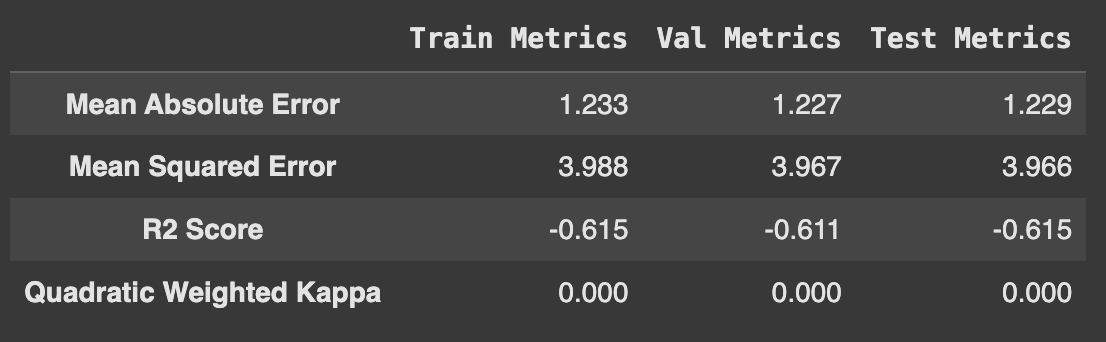

LSTM

In [ ]:
lstm_bl_metrics.round(3)

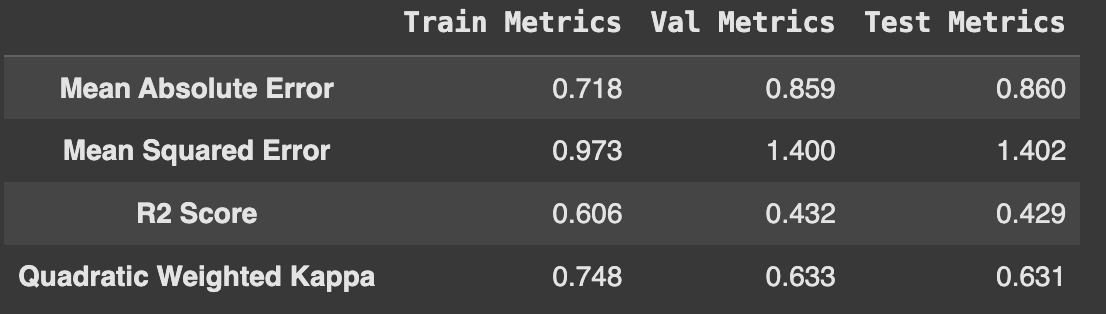

LSTM With Synonym Replacement

In [ ]:
lstm_syn_aug_metrics.round(3)

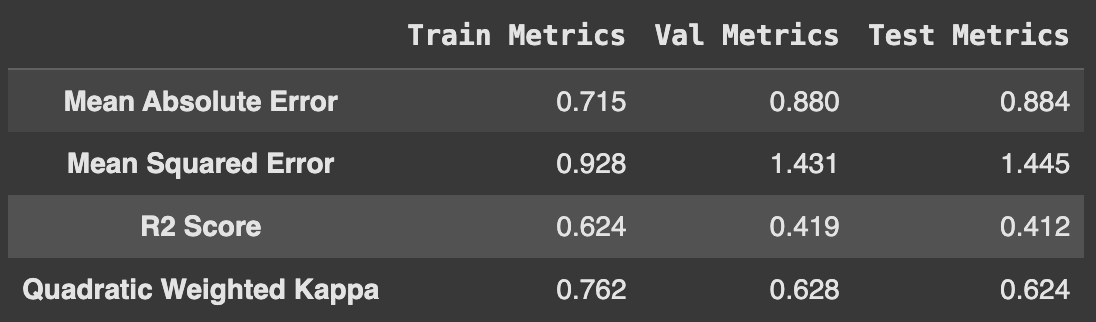

LSTM With Synonym Replacement + Random Deletion

In [ ]:
lstm_syn_and_rand_replacement_metrics.round(3)

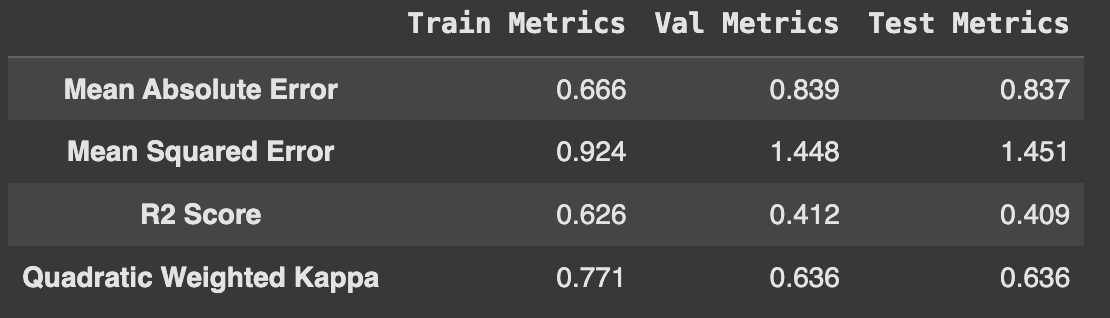

LST With Synonym Replacement + Random Deletion + Back Translation

In [ ]:
lstm_syn_and_rand_and_backtranslation_replacement_metrics.round(3)

,Train Metrics,Val Metrics,Test Metrics
Mean Absolute Error,0.708,0.869,0.866
Mean Squared Error,0.944,1.438,1.434
R2 Score,0.618,0.416,0.416
Quadratic Weighted Kappa,0.753,0.620,0.622


###Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

bins = np.arange(1, 5.5, 0.5)  # [1.0, 1.5, 2.0, ..., 5.0]
bin_labels = list(range(len(bins)))

# map continuous values to bins
test_y_true_binned = np.digitize(test_y_true, bins, right=True)
test_y_pred_binned = np.digitize(test_y_pred, bins, right=True)

# bin_labels = bins
# test_y_true_binned = bins[test_y_true_binned - 1]
# test_y_pred_binned = bins[test_y_pred_binned - 1]

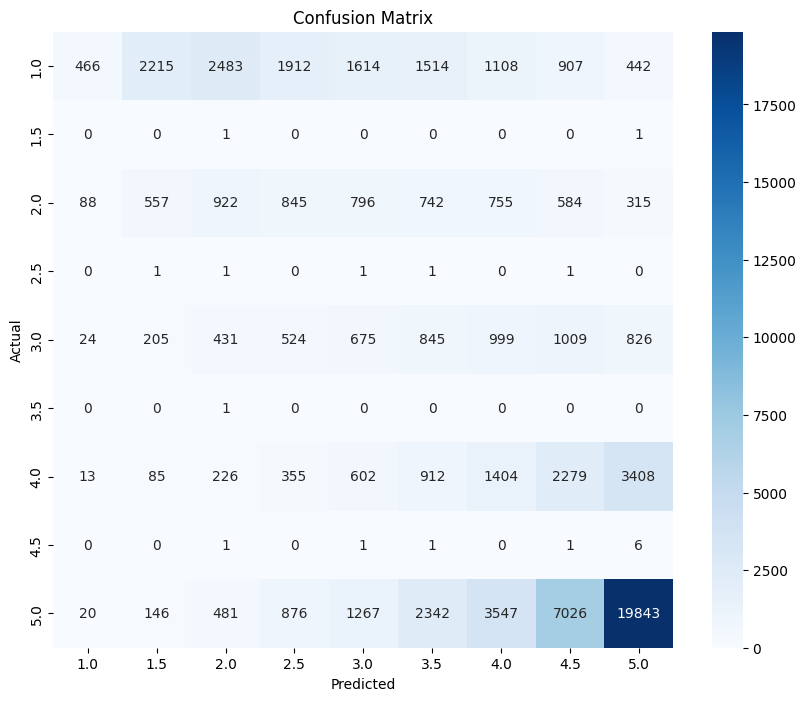

In [ ]:
cm = confusion_matrix(test_y_true_binned, test_y_pred_binned, labels=bin_labels)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cm, bins)